In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils import data
from tinyimagenet import TinyImageNet
from utils import show_images_horizontally

In [2]:
%reload_ext autoreload
%autoreload 2

## 步驟
- 讀取資料集
- 簡單 EDA
    - facets
- 定義目標 / loss function
- 定義模型
- 訓練模型
- 測試模型
- 視覺化 kernels / parameters

## 前處理資料
- 讀取資料
- 轉換（灰階處理、Augmentation、Crop）

注意在 validation 時我們不需要做 augmentation

In [3]:
root = './dataset'

In [4]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1].
# normalize 在現在有 batch-normalization 的情況下其實非必要
normalize = transforms.Normalize((.5, .5, .5), (.5, .5, .5))

augmentation = transforms.RandomApply([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64)], p=.8)

training_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    augmentation,
    transforms.ToTensor(),
    normalize])

valid_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.ToTensor(),
    normalize])

In [5]:
training_set = TinyImageNet(root, 'train', transform=training_transform)
valid_set = TinyImageNet(root, 'val', transform=valid_transform)

In [6]:
training_set

Dataset TinyImageNet
    Number of datapoints: 100000
    Split: train
    Root Location: ./dataset
    Transforms (if any): Compose(
                             Lambda()
                             RandomApply(
                             p=0.8
                             RandomHorizontalFlip(p=0.5)
                             RandomRotation(degrees=(-10, 10), resample=False, expand=False)
                             RandomResizedCrop(size=(64, 64), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                         )
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

## 顯示處理後圖片
主要是顯示經過 data augmentation 的圖片。為了讓模型更 robust，我們隨機進行水平翻轉、剪裁以及旋轉的處理。在這邊顯示的圖有進行反正規化（un-normalization）。

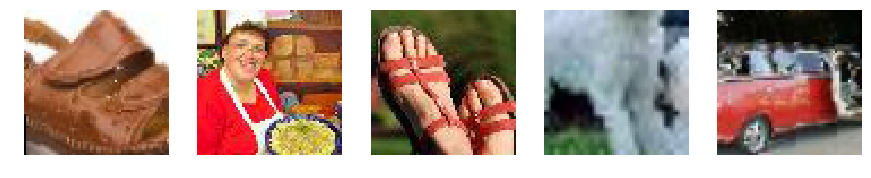

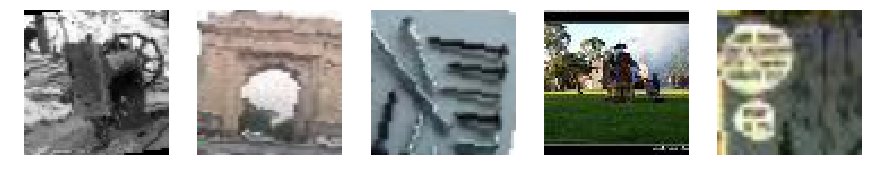

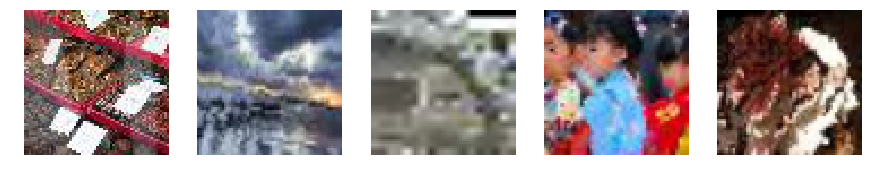

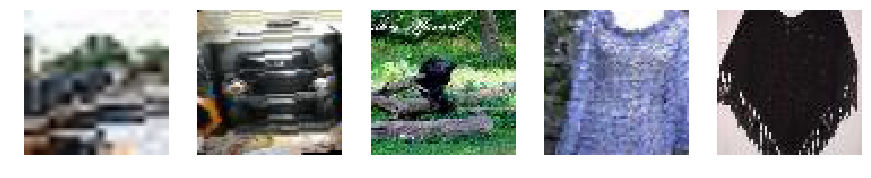

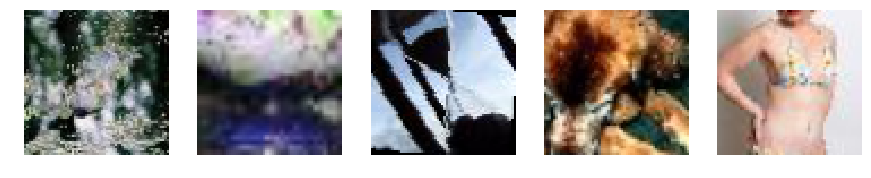

In [7]:
tmpiter = iter(data.DataLoader(training_set, batch_size=5, shuffle=True))
for _ in range(5):
    images, labels = tmpiter.next()
    show_images_horizontally(images, un_normalize=True)

## 訓練模型

In [8]:
params = {'batch_size': 64, 'shuffle': True, 'num_workers': 6}
# params = {'batch_size': 2, 'shuffle': True, 'num_workers': 1}
max_epochs = 100

In [9]:
trainloader = data.DataLoader(training_set, **params)

In [10]:
# %%time
# for epoch in range(1):
#     for idx, (data, target) in enumerate(trainloader):
#         print(data)
#         print(target)
#         print(f'{idx}/{len(training_loader)}', end='\r')
#         break

In [11]:
import torch.nn as nn

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        # compute Z[L+2]
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU(inplace=True)
        
        # downsample a[L] in case there is stride in conv1
        if stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x.clone()
        if self.downsample:
            identity = self.downsample(identity)
        return self.relu(self.conv(x) + identity)

In [13]:
block = ResidualBlock(64, 64, 1) 

In [14]:
block.conv

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [15]:
class NaiveResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.group1 = self._build_group(in_channels=3, out_channels=64, stride=2, num_blocks=2)
        self.group2 = self._build_group(in_channels=64, out_channels=128, stride=2, num_blocks=3)
        self.avgpool = nn.AvgPool2d(kernel_size=3, stride=1)
        self.fc = nn.Linear(in_features=128, out_features=num_classes)
    
    def forward(self, x):
        x = self.group1(x)
        x = self.group2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def _build_group(self, in_channels, out_channels, stride, num_blocks):
        layers = []
        layers.append(ResidualBlock(in_channels=in_channels, out_channels=out_channels, stride=stride))
        for _ in range(num_blocks - 1):
            layers.append(ResidualBlock(in_channels=out_channels, out_channels=out_channels, stride=1))
        return nn.Sequential(*layers)
    
        

In [16]:
resnet = NaiveResNet(num_classes=200)

In [17]:
from tensorboardX import SummaryWriter
from torch.autograd import Variable
dummy_input = Variable(torch.rand(16, 3, 64, 64))

with SummaryWriter(comment='NaiveResNet') as w:
    w.add_graph(resnet, (dummy_input, ))

Error occurs, checking if it's onnx problem...
Your model fails onnx too, please report to onnx team
No graph saved
